
### **Extractive Question Answering with Data from Dell Forums** ⛏️

_By Cian Prendergast_

Hello there, data enthusiasts! Today, we're diving deep into the world of Extractive Question Answering (QA). For those unfamiliar, extractive QA is all about pinpointing exact answers from large text sources. Imagine being able to instantly find the solution to a hardware issue from an ocean of forum posts. Sounds cool, right? Let's get started!


#### **Let's Dive into Scraping!**

**Why Dell?**  
We've chosen the Dell support forums, specifically the [PowerEdge-Hardware-General](https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW) section, as our data source. These forums are a goldmine of real-world hardware issues and their solutions, making them perfect for our project.

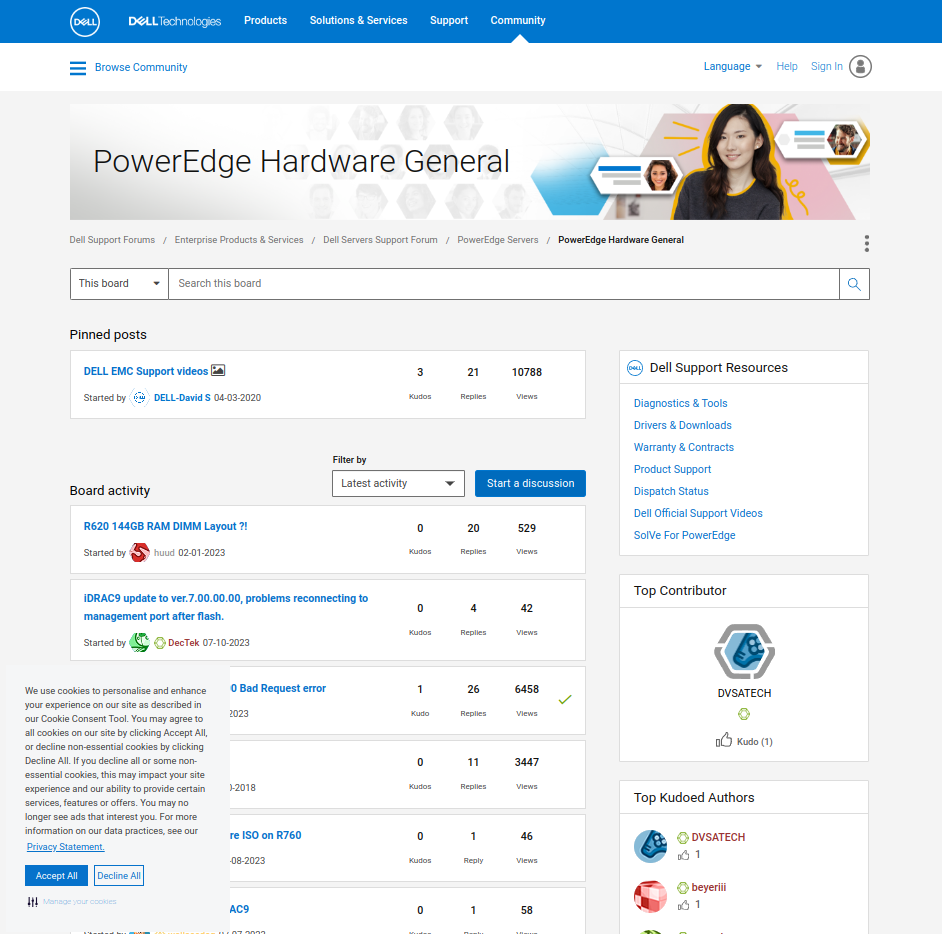


**The Challenge**:  
Web scraping isn't always a walk in the park. We encountered some challenges like:
- The pesky "Accept Cookies" button (a special shoutout to our EU-based networks!).
- The need to filter posts by "Solved" cases, ensuring we only get the cream of the crop.
- The "Load More" button that seemed to play hard-to-get by moving further down with each click.

But fear not! With a sprinkle of Python, a pinch of Selenium, and a dash of patience, we tackled these issues head-on.

**The Solution**:  
To deal with the increasing page length, we used a mix of `time.sleep()` and the `execute_script` method. This allowed us to ensure that every time we reached the bottom of the webpage, we could successfully click the "Load More" button and grab more data. For the curious, our code looks something like this:

```python
def click_accept_cookies_button(driver):
    """Click the 'Accept All' button for cookies."""
    accept_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//a[@aria-label="allow cookies"]'))
    )
    accept_button.click()

def select_solved_option(driver):
    """Select the 'Solved' option from the dropdown."""
    select_element = driver.find_element(By.ID, 'messages-loader-type')
    option_solved = select_element.find_element(By.XPATH, "//option[@value='solved']")
    option_solved.click()

def scroll_to_bottom(driver):
    """Scroll to the bottom of the page."""
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

def click_load_more(driver, num_clicks):
    """Click the 'Load more' button the specified number of times."""
    for _ in range(num_clicks):
        load_more_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'btn-load-more')))
        time.sleep(3)  # Wait before clicking
        scroll_to_bottom(driver)
        time.sleep(3)  # Wait after scrolling
        load_more_button.click()
        time.sleep(6)  # Wait after clicking

def extract_urls(driver):
    """Extract and return all href URLs on the page."""
    urls = driver.find_elements(By.XPATH, '//a[@href]')
    return [url.get_attribute('href') for url in urls]

def automate_dell_forum(num_clicks):
    # Instantiate the Selenium web driver
    driver = webdriver.Chrome()
    driver.maximize_window()  # Maximize the browser window

    # Navigate to the Dell community forum page
    driver.get('https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW')

    click_accept_cookies_button(driver)
    select_solved_option(driver)
    
    # Wait for the page to load after selecting "Solved" option
    time.sleep(2)
    scroll_to_bottom(driver)
    time.sleep(2)  # Wait before clicking "Load more"

    click_load_more(driver, num_clicks)
    
    # Extract URLs
    url_list = extract_urls(driver)

    # Close the Selenium web driver
    driver.quit()

    return url_list

# Refactored function usage remains the same
url_list = automate_dell_forum(189)  # To run with 189 clicks



```

After some clicks and scrolls, we saved the scraped URLs to a CSV file and a text file. We now have a treasure trove of forum posts ready for our next steps!

> If your wondering how I was able to figure out which HTML elements to target, its simple a matter of using a browsers Developer Tools and going down the tree, seeing what gets highlighted. I will go into more details in a future blog post!


---

### **Filtering and Cleaning: Getting the Best Data**

Once we scraped our data, we were left with a vast list of URLs. However, not every URL was relevant to our goals. To sift through the noise and get to the good stuff, we implemented a filtering function:

```python
def filtered_urls(url_list):
    filtered_urls = []
    exclude_urls = [
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW#',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.solutions.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.careers.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.about.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW'
    ]
    for url in url_list:
        if url.startswith('https://www.dell.com/community/PowerEdge-Hardware-General/') and url not in exclude_urls:
            filtered_urls.append(url)
    return filtered_urls

# Filter the urls
filtered_urls = filtered_urls(url_list)
```

### **Extracting the Essence: Questions and Answers**

With our refined list of URLs, we proceeded to extract the real treasures: the questions and answers from the forum posts. 

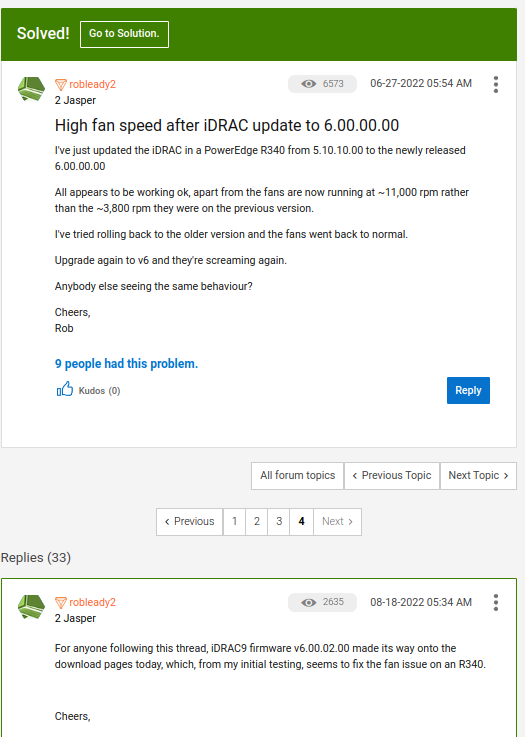


Using the power of BeautifulSoup, we devised a function to navigate each URL and fetch the required data:

```python
def extract_elements_with_class(urls, class_name):
    elements_list = []
    session = requests.Session()
    for url in tqdm(urls, desc="Extracting elements"):
        try:
            response = session.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            elements = soup.find_all(class_=class_name, limit=2)  # Limit to the first two elements
            for element in elements:
                elements_list.append(element.text.strip())
            for _ in range(2 - len(elements)):
                elements_list.append("")  # Append empty strings if elements are not found
        except requests.exceptions.RequestException:
            elements_list.extend(["", ""])  # Append empty strings if there's an error
    return elements_list

class_name = "lia-message-body-content"
extracted_elements = extract_elements_with_class(filtered_urls, class_name)

# Ensure extracted_elements has an even number of elements
if len(extracted_elements) % 2 != 0:
    extracted_elements.append("")  # Append an empty string to make it even

# Split the extracted elements into Questions and Answers lists
Questions = extracted_elements[::2]
Answers = extracted_elements[1::2]

# Create a dataframe called QA
QA = pd.DataFrame({"Questions": Questions, "Answers": Answers})
```

This function allowed us to neatly segment our data into questions and their corresponding answers, paving the way for the creation of our `QA_large` DataFrame.

Data is most useful when it's clean and organized. To this end, we saved our carefully curated dataset into a CSV file:

```python
QA_large.to_csv('QA_large_cleaned.csv', index=False)
```



--------

### **SQUaD Format with Haystack Annotation**

Models trained alreasy on the SQuAD dataset will [expect new smaller closed domain datasets to follow the same strucure](https://github.com/nlp-with-transformers/notebooks).

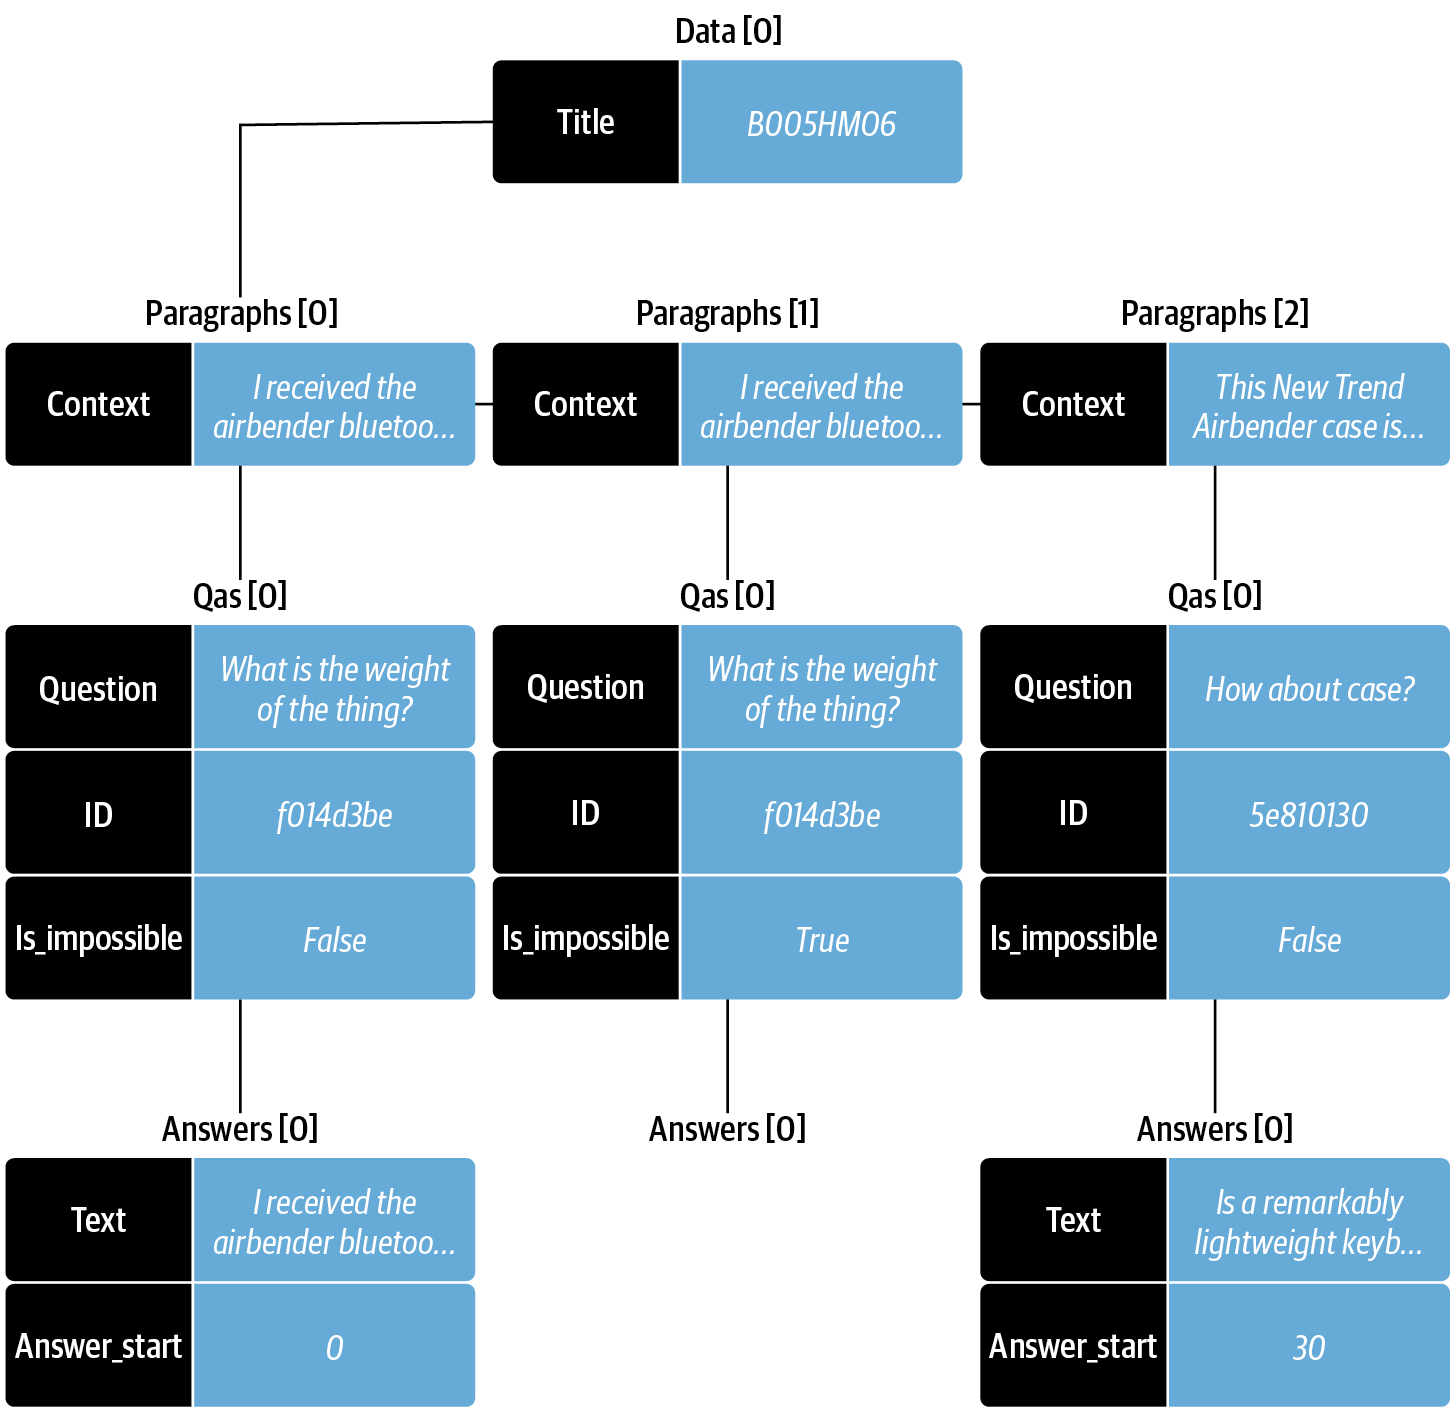

This is where the [Haystack Annoptation tool](https://www.deepset.ai/blog/labeling-data-with-haystack-annotation-tool) comes in, not only is its a GUI that allows us to highlight answer spans, it automatically exports in the expected SQuAD nested JSON format!

> **Please note:** Deepset will shortly no longer support the online tool, you will have to run it locally via Docker, please see details [here](https://docs.haystack.deepset.ai/docs/annotation#installing-the-local-version-docker).

For importing our data into the annptation tool, we must use comma separated `CSVs` and include the header in the first line. You might also want to wrap text around quotation marks, e.g. if it contains commas. We always use pandas `to_csv` method, this should format the file in the right way.

Example:

```
docs.csv:
document_identifier,document_text
id1,bbbbb
id2,muh
```
the same holds for the questions.csv:
```
question,document_identifier,question_identifier
question1,id1,qid1
question2,id2,qid2

```

We can no use the tool to highlight relevant passages from the community answers:

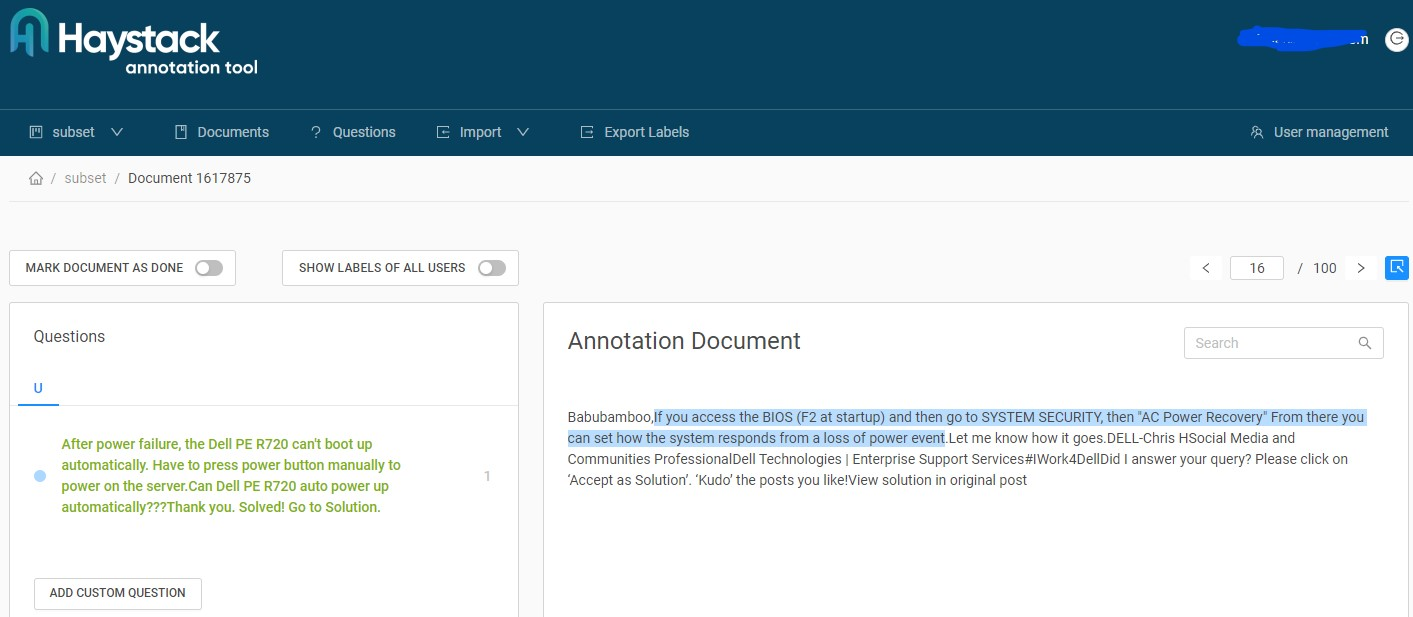


Once we have highlighted the answer spans, we can export and save as JSON file (`Dell_QA_200.json)`. Now are dataset is structured as so: 

```python

import json

with open('Dell_QA_200.json', 'r') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4))  # A pretty print to visualize the dataset.

```

```
{
    "data": [
        {
            "paragraphs": [
                {
                    "qas": [
                        {
                            "question": "Does v9 license works with v8 platform?When I try to import the v9 license I am having this error. LIC017.\u00a0",
                            "id": 1082044,
                            "answers": [
                                {
                                    "answer_id": 980739,
                                    "document_id": 1619992,
                                    "question_id": 1082044,
                                    "text": "IDRAC v9 license is not compatible with iDRAC V8 platforms.",
                                    "answer_start": 0,
                                    "answer_end": 59,
                                    "answer_category": null
                                }
                            ],
                            "is_impossible": false
                        }
                    ],
                    "context": "IDRAC v9 license is not compatible with iDRAC V8 platforms. IDRAC license is tied with each system and you will not be able to install on another system other than the server it is intended.Thanks,DELL-Shine K#IWork4DellView solution in original post",
                    "document_id": 1619992
                }
```



### **Question and Answer Length**

Later we come across an issue with the Haystack annotation tool and its restriction to 255 characters for questions. So lets quickly check how many questions exceed that length limit: 

```python
# Get the length of each text entry in 'column_1'
df['text_length'] = df['document_text'].str.len()

# Calculate average, highest, and lowest length
average_length = df['text_length'].mean()
max_length = df['text_length'].max()
min_length = df['text_length'].min()

# Calculate percentage of entries with length greater than 255 characters
percentage_over_255 = (df[df['text_length'] > 255].shape[0] / df.shape[0]) * 100

print(f"Average Length: {average_length:.2f}")
print(f"Maximum Length: {max_length}")
print(f"Minimum Length: {min_length}")
print(f"Percentage of Texts over 255 characters: {percentage_over_255:.2f}%")
```

```
Average Length: 597.39
Maximum Length: 27039
Minimum Length: 0
Percentage of Texts over 255 characters: 79.01%
```

We can also plot these:

```python
import matplotlib.pyplot as plt

# Assuming you have already calculated 'average_length' and have a DataFrame 'df'

plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, range=(0, 3000), color='skyblue', edgecolor='black')  # Adjusted bins and range
plt.axvline(average_length, color='red', linestyle='dashed', linewidth=1, label=f"Average Length: {average_length:.2f}")
plt.axvline(255, color='green', linestyle='dotted', linewidth=1, label="Length: 255 characters")
plt.title("Distribution of Text Lengths in 'column_1'")
plt.xlabel('Text Length')
plt.ylabel('Number of Entries')
plt.legend()
plt.grid(axis='y')
plt.show()
```
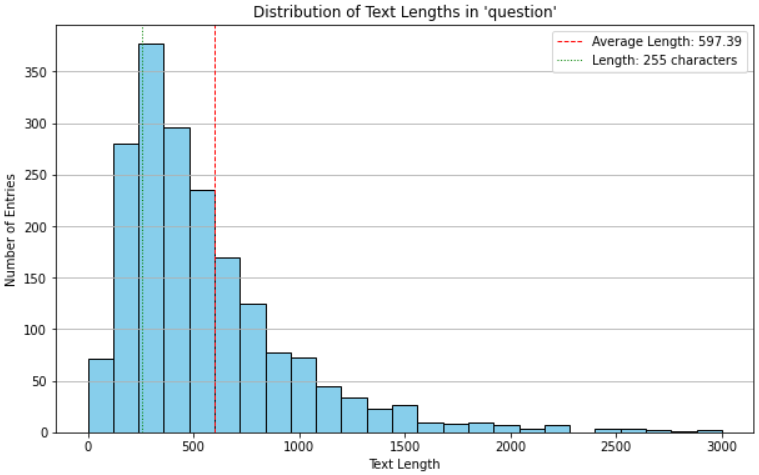

### **255 char limit**


We've observed that a significant portion of questions are longer than 255 characters. This isn't surprising given the need for detailed explanations of technical challenges and prior troubleshooting. This unexpected length initially led us to truncate questions, unfortunately losing valuable information. Going forward, we could segment longer questions and later recombine them after annotation. Alternatively, we could narrow our focus to questions of 255 characters or fewer, but this would exclude a vast 79% of our dataset. Importantly, there's no character limit for answers, a design influenced by the original SQuAD's emphasis on concise questions derived from comprehensive Wikipedia content.

My approach, while inspired by SQuAD and the [TechQA project](https://arxiv.org/abs/1911.02984), focuses more on real-world, detailed questions and succinct forum answers. Solely highlighting articles referenced in answers, like how-to guides, would mean losing vital reasoning context. Consider the example below:

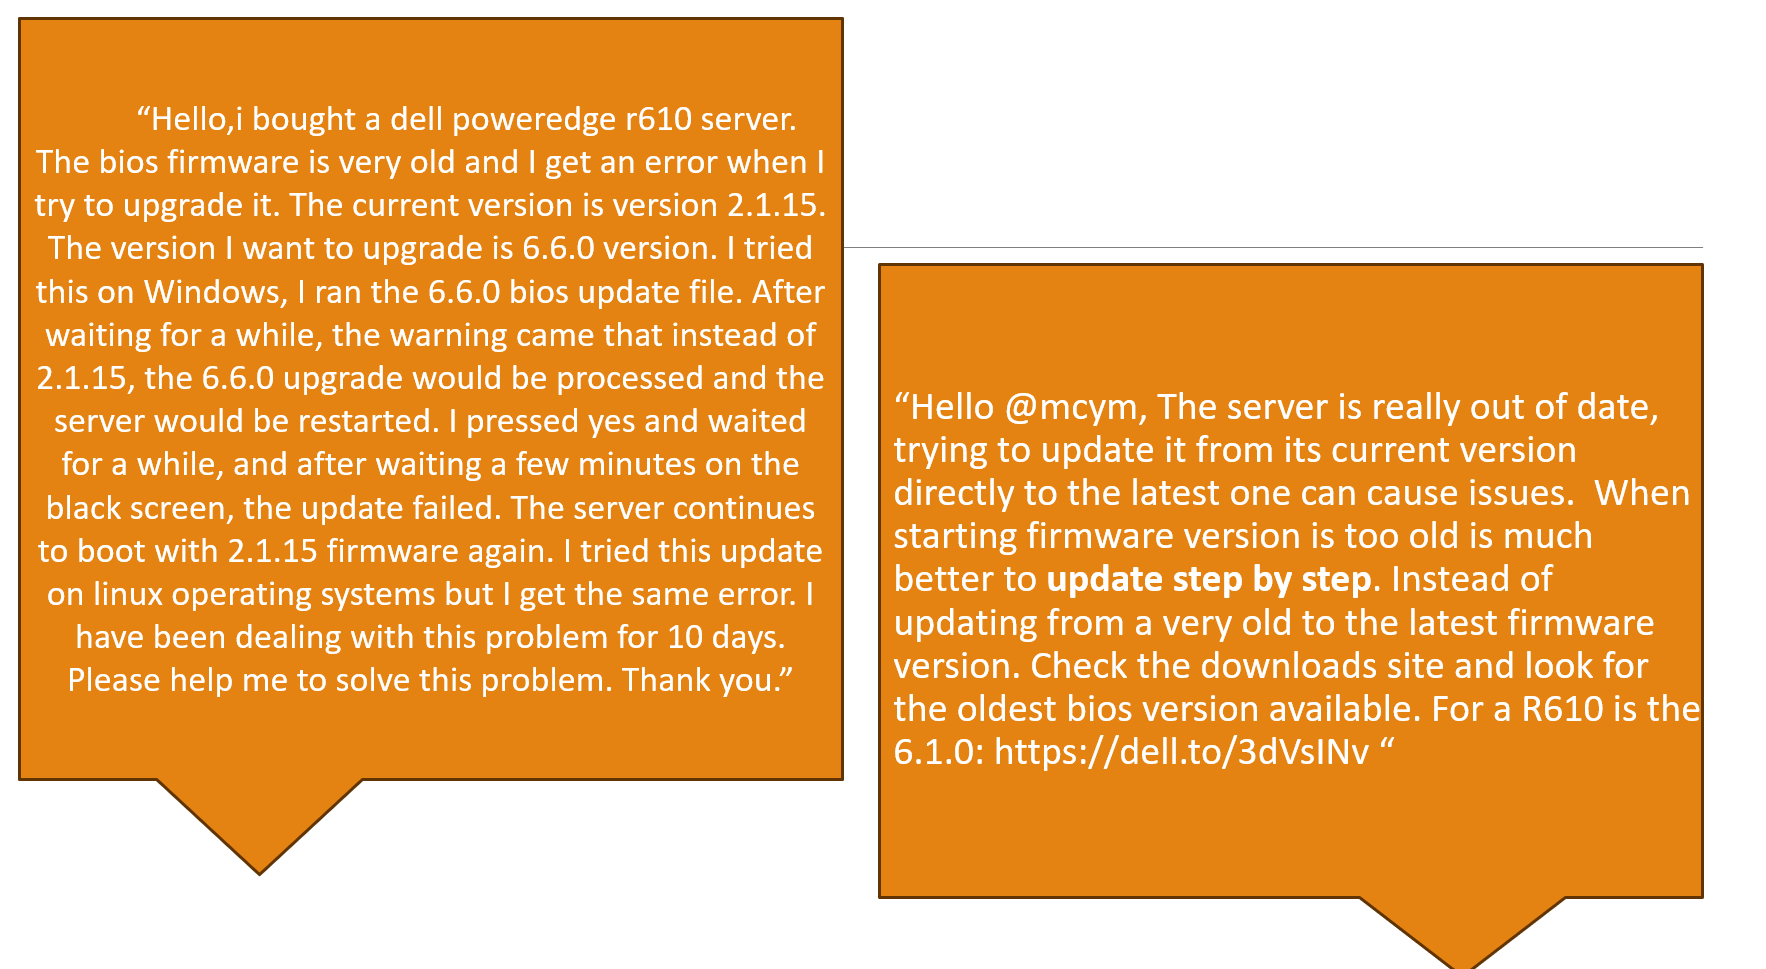

Using only the firmware landing page linked [here](https://dell.to/3dVsINv) from the above answer would deprive us of essential "step-by-step update" details.


### **Training the Dell QA Model: A Deep Dive** 

So our dataset is stored in a file named `Dell_QA_200.json`. We can transform this intricate JSON structure into a more palatable DataFrame:

```python
rows = []
for dat in data['data']:
    for paragraph in dat['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            for answer in qa['answers']:
                answer_text = answer['text']
                answer_start = answer['answer_start']
                rows.append([question, answer_text, answer_start, context])

df = pd.DataFrame(rows, columns=['question', 'answers.text', 'answers.answer_start', 'context'])
```

### Crafting the Train/Test Split

Before diving into training, it's crucial to split our dataset. We've reserved 80% for training and set aside the remaining 20% for testing:

```python
import random

random.shuffle(squad_data["data"])

train_size = int(0.8 * len(squad_data["data"]))
test_size = len(squad_data["data"]) - train_size
train_data = squad_data["data"][:train_size]
test_data = squad_data["data"][train_size:]

# Saving them for posterity (and our model!)
with open('Dell_QA_200_train.json', 'w') as train_file:
    json.dump({"data": train_data}, train_file)
    
with open('Dell_QA_200_test.json', 'w') as test_file:
    json.dump({"data": test_data}, test_file)
```

---





## **Tokenization: The First Step Towards Understanding** 

Welcome back! If you remember from our last post, we dived deep into preparing our data. This time, let’s talk about how we make sense of this data: **Tokenization**.

### What's Tokenization Anyway?

In simple terms, tokenization is the process of converting our text (questions and contexts) into smaller chunks, called tokens. This is an essential step because our models don't understand text as we do; they understand numbers. Tokens are a bridge between human-readable text and machine-understandable numbers.

```python
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
```

Using a sample question and context, we can see tokenization in action:

```python
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
```


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>...</th>
      <th>18</th>
      <th>19</th>
      <th>20</th>
      <th>21</th>
      <th>22</th>
      <th>23</th>
      <th>24</th>
      <th>25</th>
      <th>26</th>
      <th>27</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>input_ids</th>
      <td>101</td>
      <td>2129</td>
      <td>2172</td>
      <td>2189</td>
      <td>2064</td>
      <td>2023</td>
      <td>2907</td>
      <td>1029</td>
      <td>102</td>
      <td>2019</td>
      <td>...</td>
      <td>2061</td>
      <td>2055</td>
      <td>25961</td>
      <td>2847</td>
      <td>5834</td>
      <td>2006</td>
      <td>5371</td>
      <td>2946</td>
      <td>1012</td>
      <td>102</td>
    </tr>
    <tr>
      <th>token_type_ids</th>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>...</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>attention_mask</th>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>...</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
<p>3 rows × 28 columns</p>
</div>



### **Simplifying with Pipelines**

`Transformers` offer a nifty feature called pipelines, which simplifies our QA process:

```python
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)
```

But what if our context doesn't contain the answer? The pipeline gracefully handles such scenarios:

```python
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)
```

```
{'score': 0.906841516494751, 'start': 0, 'end': 0, 'answer': ''}
```


---

### **Sliding Windows: Seeing the Bigger Picture**

Remember the challenge of tokenizing long passages? The sliding window approach is our knight in shining armor. By using `return_overflowing_tokens=True` and specifying a `stride`, we ensure that our model gets overlapping views of a passage without missing any potential answers.

Let's see it in action:

```python
example = df.iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)
```

Each window has a specific number of tokens:

```python
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")
```

```
Window #0 has 89 tokens

```

When we decode these tokens, we can visualize the overlapping windows:

```python
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")
```
    
```
[CLS] does v9 license works with v8 platform? when i try to import the v9 license i am having this error. lic017. [SEP] idrac v9 license is not compatible with idrac v8 platforms. idrac license is tied with each system and you will not be able to install on another system other than the server it is intended. thanks, dell - shine k # iwork4dellview solution in original post [SEP] 
```

With this setup, our model gets a comprehensive view of the context, ensuring we don't miss out on potential answers.

### **ElasticSearch: Turbocharging Our QA System**

ElasticSearch is a powerhouse for search and analytics. It's our chosen tool to index and retrieve relevant contexts efficiently when posing questions.

Setting it up involves:

1. Downloading ElasticSearch:
```python
url = "https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.9.0-linux-x86_64.tar.gz"
!wget -nc -q {url}
!tar -xzf elasticsearch-8.9.0-linux-x86_64.tar.gz
```

2. Performing system configurations:
```python
!sudo usermod -aG docker $USER
!sudo reboot
```

3. Installing required packages:
```python
!pip install --upgrade numexpr
```

With ElasticSearch in place, our QA system is turbocharged, ensuring rapid and accurate retrievals.




### **Launching ElasticSearch (The Docker Way)**

For those using Docker, here's a quick way to get ElasticSearch up and running:

```python
from haystack.utils import launch_es

launch_es()
```

A quick check to ensure ElasticSearch is running:

```bash
!curl -X GET "localhost:9200/?pretty"
```

### **Populating ElasticSearch: From DataFrame to DocumentStore**

To make our data retrievable, we need to format it appropriately and populate our ElasticSearch index:

```python
docs = []

# Convert DataFrame rows to dictionary format for the DocumentStore
for _, row in df.iterrows():
    doc = {
        'content': row['context'], 
        'meta': {}  # You can add additional metadata here if needed.
    }
    docs.append(doc)

# Populate the DocumentStore
document_store.write_documents(docs, index="document")
```

### **BM25: Simple Yet Powerful**

BM25 is a classic technique in information retrieval. Let's initialize it and see it in action:

```python
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)
```

A quick retrieval test:

```python
query = "How to fix my KVM?"
retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3)

print(retrieved_docs[0])
```

```
<Document: id=1a93a3494d130482abb1d9341f3a4642, content='With a KVM  you really will need to do some deductive troubleshooting.If port one is the only port w...'>
```

### **Dense Passage Retrieval (DPR)**

While BM25 is great, there's another retrieval technique on the horizon: DPR. It's a more advanced method that uses deep learning to understand context and provide better results. You can learn more about DPR [here](https://huggingface.co/docs/transformers/model_doc/dpr). 





DPR offers a more granular retrieval technique, diving deeper into our contexts to find the most relevant snippets:

```python
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False
)
```

With DPR initialized, it's time to update our document embeddings:

```python
document_store.update_embeddings(retriever=dpr_retriever)
```

### **The Power of Pipelines**

By combining our retriever and reader, we form a powerful QA pipeline:

```python
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=dpr_retriever)
```

Let's see this in action:

```python
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Answer {idx+1}: {preds['answers'][idx].answer}")


for idx in range(n_answers):
    print(f"Question {idx+1}: {preds['answers'][idx].answer}")
    print(f"Answer snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")
```

```
Question 3: I want to buy DDR3L HPE 647883-B21 16Gb DIMM ECC Reg PC3-10600 CL9This modules may not be supported.Kingston for Dell (317-6142 370-20147) DDR3 DIMM 16GB (PC3-10600) 1333MHz ECC Registered Low Voltage ModuleThis module can be used.
Answer snippet: ....I want to buy DDR3L HPE 647883-B21 16Gb DIMM ECC Reg PC3-10600 CL9This modules may not be supported.Kingston for Dell (317-6142 370-20147) DDR3 DIMM 16GB (PC3-10600) 1333MHz ECC Registered Low Voltage ModuleThis module can be used....
```




###  **Fine-Tuning & Evaluation**

While our models are pretrained on diverse data, fine-tuning helps adapt them to our specific use case:

```python
from pathlib import Path
import torch

def train_and_evaluate():
    # Initialize model, optimizer, loss function, etc.
    train_filename = "Dell_QA_200_train.json"
    dev_filename = "Dell_QA_200_test.json"
    test_filename = "Dell_QA_200_test.json"  # or another test file
    data_dir = Path(".")  # using pathlib's Path
    save_dir = "./model"

    # Fine-tuning your model
    reader.train(data_dir=data_dir, use_gpu=True, n_epochs=1, batch_size=16,
                 train_filename=train_filename, save_dir=save_dir)

    # Evaluate the model
    result = reader.eval_on_file(data_dir=data_dir, test_filename=test_filename, device="cuda" if torch.cuda.is_available() else "cpu")
    print(result)

# Call the function to start the process
train_and_evaluate()

```

The above snippet demonstrates how we fine-tune our reader on the Dell QA dataset, optimizing it for our domain.

### **Metrics: The Scorecards of AI**

Evaluation is crucial in understanding how well our system performs. Some key metrics include:

- **Exact Match (EM)**: Measures the percentage of predictions that match any one of the ground truth answers exactly.
- **F1 Score**: Considers both the precision and the recall of the test to compute the score.
- **Top_n_accuracy**: Evaluates how often the correct answer is within the top n retrieved results.

After fine-tuning with `train_and_evaluate()`, our evaluation showcased impressive results:

```python
{
 'EM': 27.50, 'f1': 44.76, 'top_n_accuracy': 67.5, 
 'top_n': 4, 'EM_text_answer': 24.32, 'f1_text_answer': 42.98, 
 ...
}

```

These metrics offer a comprehensive view of our model's performance, highlighting areas of excellence and potential improvement.


---


### **Conclusion**

So that is my attempt at using Exctractive QA! With Deepset dropping it support for the online version of Haystack Annotation tool, I suspect many people are moving towards Generative QA system - I will be doing a blog post on this shortly! 

My full code and datasets are [here](https://github.com/c123ian/Dell_QA) on my GitHub.

Happy coding!